<a href="https://colab.research.google.com/github/maloyan/pollen2020/blob/master/pollen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://iplab.dmi.unict.it/pollenclassificationchallenge/train.zip

--2020-06-21 08:02:46--  https://iplab.dmi.unict.it/pollenclassificationchallenge/train.zip
Resolving iplab.dmi.unict.it (iplab.dmi.unict.it)... 151.97.252.83
Connecting to iplab.dmi.unict.it (iplab.dmi.unict.it)|151.97.252.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245112014 (234M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 233.76M  10.4MB/s    in 24s     

2020-06-21 08:03:12 (9.55 MB/s) - ‘train.zip’ saved [245112014/245112014]



In [ ]:
!wget https://iplab.dmi.unict.it/pollenclassificationchallenge/test.zip

--2020-06-21 08:03:12--  https://iplab.dmi.unict.it/pollenclassificationchallenge/test.zip
Resolving iplab.dmi.unict.it (iplab.dmi.unict.it)... 151.97.252.83
Connecting to iplab.dmi.unict.it (iplab.dmi.unict.it)|151.97.252.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27597819 (26M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>]  26.32M  6.10MB/s    in 4.3s    

2020-06-21 08:03:18 (6.10 MB/s) - ‘test.zip’ saved [27597819/27597819]



In [ ]:
!unzip train.zip
!unzip test.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/images/3/train_SEGM/20190404114349_SEGM_0_899_912.png  
  inflating: train/images/3/train_SEGM/20190404114349_SEGM_14_1238_320.png  
  inflating: train/images/3/train_SEGM/20190404114349_SEGM_18_238_163.png  
  inflating: train/images/3/train_SEGM/20190404114349_SEGM_21_510_54.png  
  inflating: train/images/3/train_SEGM/20190404114349_SEGM_23_887_477.png  
  inflating: train/images/3/train_SEGM/20190404114349_SEGM_2_997_897.png  
  inflating: train/images/3/train_SEGM/20190404114349_SEGM_3_414_803.png  
  inflating: train/images/3/train_SEGM/20190404114349_SEGM_5_350_612.png  
  inflating: train/images/3/train_SEGM/20190404114349_SEGM_6_68_551.png  
  inflating: train/images/3/train_SEGM/20190404114349_SEGM_7_202_526.png  
  inflating: train/images/3/train_SEGM/20190404114349_SEGM_8_373_481.png  
  inflating: train/images/3/train_SEGM/20190404114349_SEGM_9_464_466.png  
  inflating: train/images/3/train_SEGM/2019040

In [ ]:
!pip install pytorch_lightning

     |████████████████████████████████| 296kB 2.8MB/s 
     |████████████████████████████████| 829kB 8.7MB/s 
     |████████████████████████████████| 276kB 15.8MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=bfef54a2b4d7130c7104bc7cf9ce1ea9ea513cca9a17013b6da55a760ccf04a3
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=53b865bf5282ee694e147f1f0ec1bd1257683ecf95f36f49fc7c2b92f3612ced
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built future PyYAML
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
import random
import argparse
from pathlib import Path
import PIL.Image as Image
import pandas as pd
import numpy as np
import cv2
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

import pytorch_lightning as pl
import torch.utils.data as tdata
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms

In [ ]:
# train
img_path = []
label = []

IMG_PATH = './train/images/'
for i in os.listdir(IMG_PATH):
    path = os.path.join(IMG_PATH, i, 'train_OBJ')
    for j in os.listdir(path):
        img_path.append(os.path.join(path, j))
        label.append(i)

train_df = pd.DataFrame({'img_path': img_path, 'target': label})
train_df.head()

,img_path,target
0,./train/images/3/train_OBJ/20190404111912_OBJ_...,3
1,./train/images/3/train_OBJ/20190404113719_OBJ_...,3
2,./train/images/3/train_OBJ/20190404111413_OBJ_...,3
3,./train/images/3/train_OBJ/20190404105854_OBJ_...,3
4,./train/images/3/train_OBJ/20190404114013_OBJ_...,3


In [ ]:
# test
img_path_test = []

IMG_PATH = './test/images/'
for i in os.listdir(IMG_PATH):
    path = os.path.join(IMG_PATH, i)
    img_path_test.append(path)

test_df = pd.DataFrame({'img_path': img_path_test})
test_df.head()

,img_path
0,./test/images/20190404113255_OBJ_38_1224_449.png
1,./test/images/20190404114614_OBJ_23_784_274.png
2,./test/images/20190402170312_OBJ_4_861_329.png
3,./test/images/20190404110633_OBJ_19_752_529.png
4,./test/images/20190404111421_OBJ_19_900_495.png


In [ ]:
# Reproductibility
SEED = 33
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
def dict_to_args(d):

    args = argparse.Namespace()

    def dict_to_args_recursive(args, d, prefix=''):
        for k, v in d.items():
            if type(v) == dict:
                dict_to_args_recursive(args, v, prefix=k)
            elif type(v) in [tuple, list]:
                continue
            else:
                if prefix:
                    args.__setattr__(prefix + '_' + k, v)
                else:
                    args.__setattr__(k, v)

    dict_to_args_recursive(args, d)
    return args

In [ ]:
#train_df = pd.read_csv('train_folds.csv')
#test_df = pd.read_csv('test.csv')
#IMAGE_DIR = Path('/kaggle/input/siim-isic-melanoma-classification/jpeg')  # Use this when training with original images
#IMAGE_DIR = Path('/kaggle/input/siic-isic-224x224-images/')

In [ ]:
train_df.head()

,img_path,target
0,./train/images/3/train_OBJ/20190404111912_OBJ_...,3
1,./train/images/3/train_OBJ/20190404113719_OBJ_...,3
2,./train/images/3/train_OBJ/20190404111413_OBJ_...,3
3,./train/images/3/train_OBJ/20190404105854_OBJ_...,3
4,./train/images/3/train_OBJ/20190404114013_OBJ_...,3


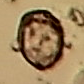

In [ ]:
Image.open(train_df.iloc[0].img_path)

In [ ]:
class SIIMDataset(tdata.Dataset):
    
    def __init__(self, df, transform, test=False):
        self.df = df
        self.transform = transform
        self.test = test
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        meta = self.df.iloc[idx]
        image_fn = meta['img_path']
        if self.test:
            img = Image.open(image_fn)
        else:
            img = Image.open(image_fn)
        
        if self.transform is not None:
            img = self.transform(img)
        
        if self.test:
            return {'image': img}
        else:
            return {
                'image': img, 
                'target': int(meta['target']) - 1
            }

## Model

In [ ]:
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.max = nn.AdaptiveMaxPool2d(output_size=(1, 1))

    def forward(self, x):
        avg_x = self.avg(x)
        max_x = self.max(x)
        return torch.cat([avg_x, max_x], dim=1)


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)
    

class Model(nn.Module):
    
    def __init__(self, c_out=4, arch='seresnext50'):
        super().__init__()
        if arch == 'resnet34':
            remove_range = 2
            m = models.resnet34(pretrained=True)
        elif arch == 'seresnext50':
            m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnext50_32x4d_ssl')
            remove_range = 2
            
        c_feature = list(m.children())[-1].in_features
        self.base = nn.Sequential(*list(m.children())[:-remove_range])
        self.head = nn.Sequential(AdaptiveConcatPool2d(),
                                  Flatten(),
                                  nn.Linear(c_feature * 2, c_out))

        
    def forward(self, x):
        h = self.base(x)
        logits = self.head(h).squeeze(1)
        return logits


## Pytorch Lightning module definition

In a normal pytorch code you probably would instantiate the model, dataloaders and make a nested for loop for epochs and batches. Pytorch lightning automates the engineering parts like the loops so that you focus on the ML part. To do that you create a pytorch lightning model and then define every ML step inside of it. To help you understand I have added comments under every method you need to implement.


In [ ]:
import torch.nn.functional as F
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(
            inputs,
            torch.tensor(targets, dtype=torch.long).cuda(), #targets, 
            reduction='none'
        )
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [ ]:
class LightModel(pl.LightningModule):

    def __init__(self, df_train, df_test, pid_train, pid_val, hparams):
        super().__init__()
        self.df_train = df_train
        self.df_test = df_test
        
        self.model = Model(arch=hparams.arch)  # You will obviously want to make the model better :)

        self.hparams = hparams
        
        # Defining datasets here instead of in prepare_data usually solves a lot of problems for me...
        self.transform_train = transforms.Compose([
            transforms.Resize((224, 224)),   # Use this when training with original images
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomVerticalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225])
        ])
        self.transform_test = transforms.Compose([
            transforms.Resize((224, 224)),   # Use this when training with original images
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225])
        ])
        self.trainset = SIIMDataset(self.df_train.iloc[pid_train], self.transform_train)
        self.valset = SIIMDataset(self.df_train.iloc[pid_val], self.transform_test)
        self.testset = SIIMDataset(self.df_test, self.transform_test, test=True)

    def forward(self, batch):
        return self.model(batch['image'])

    def prepare_data(self):
        # This is called at the start of training
        pass

    def train_dataloader(self):
        # Simply define a pytorch dataloader here that will take care of batching. Note it works well with dictionnaries !
        train_dl = tdata.DataLoader(self.trainset, batch_size=self.hparams.batch_size, shuffle=True,
                                    num_workers=os.cpu_count())
        return train_dl

    def val_dataloader(self):
        # Same but for validation. Pytorch lightning allows multiple validation dataloaders hence why I return a list.
        val_dl = tdata.DataLoader(self.valset, batch_size=self.hparams.batch_size, shuffle=False,
                                  num_workers=os.cpu_count()) 
        return [val_dl]
    
    def test_dataloader(self):
        test_dl = tdata.DataLoader(self.testset, batch_size=self.hparams.batch_size, shuffle=False,
                                  num_workers=os.cpu_count()) 
        return [test_dl]
    

    def loss_function(self, logits, gt):
        # How to calculate the loss. Note this method is actually not a part of pytorch lightning ! It's only good practice
        #loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([32542/584]).to(logits.device))  # Let's rebalance the weights for each class here.
        loss_fn = FocalLoss(logits=True)
        gt = gt.float()
        loss = loss_fn(logits, gt)
        return loss

    def configure_optimizers(self):
        # Optimizers and schedulers. Note that each are in lists of equal length to allow multiple optimizers (for GAN for example)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams.lr, weight_decay=3e-6)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=10 * self.hparams.lr, 
                                                        epochs=self.hparams.epochs, steps_per_epoch=len(self.train_dataloader()))
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # This is where you must define what happens during a training step (per batch)
        logits = self(batch)
        loss = self.loss_function(logits, batch['target']).unsqueeze(0)  # You need to unsqueeze in case you do multi-gpu training
        # Pytorch lightning will call .backward on what is called 'loss' in output
        # 'log' is reserved for tensorboard and will log everything define in the dictionary
        return {'loss': loss, 'log': {'train_loss': loss}}

    def validation_step(self, batch, batch_idx):
        # This is where you must define what happens during a validation step (per batch)
        logits = self(batch)
        loss = self.loss_function(logits, batch['target']).unsqueeze(0)
        probs = torch.sigmoid(logits)
        return {'val_loss': loss, 'probs': probs, 'gt': batch['target']}
    
    def test_step(self, batch, batch_idx):
        logits = self(batch)
        probs = torch.sigmoid(logits)
        return {'probs': probs}

    def validation_epoch_end(self, outputs):
        # This is what happens at the end of validation epoch. Usually gathering all predictions
        # outputs is a list of dictionary from each step.
        avg_loss = torch.cat([out['val_loss'] for out in outputs], dim=0).mean()
        probs = torch.cat([out['probs'] for out in outputs], dim=0)
        gt = torch.cat([out['gt'] for out in outputs], dim=0)
        probs = probs.detach().cpu().numpy()
        gt = gt.detach().cpu().numpy()
        #print(probs)
        #print(gt, [np.argmax(i) for i in probs])
        
        acc = torch.tensor(accuracy_score(gt, [np.argmax(i) for i in probs]))
        tensorboard_logs = {'val_loss': avg_loss, 'acc': acc}
        print(f'Epoch {self.current_epoch}: {avg_loss:.2f}, acc: {acc:.4f}')

        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}
    
    def test_epoch_end(self, outputs):
        probs = torch.cat([out['probs'] for out in outputs], dim=0)
        probs = probs.detach().cpu().numpy()
        self.test_predicts = probs  # Save prediction internally for easy access
        # We need to return something 
        return {'dummy_item': 0}


## Training

Let's start by specifying parameters, the seed and output folder.


In [ ]:
# dict_to_args is a simple helper to make hparams act like args from argparse. This makes it trivial to then use argparse
OUTPUT_DIR = './lightning_logs'
hparams = dict_to_args({
    'batch_size': 64,
    'lr': 1e-4,
    'epochs': 10,
    'arch': 'seresnext50'
})

For training we just need to instantiate the pytorch lightning module and a trainer with a few options. Most importantly this is where you specify how many GPU to use (or TPU) and if you want to do mixed precision training (with apex). For the purpose of this kernel I just do FP32 1GPU training but please read the pytorch lightning doc if you want to try TPU and/or mixed precision.

In [ ]:
# Initiate model
preds = None
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_ind, val_ind) in enumerate(skf.split(train_df, train_df.target)):
    print(f'FOLD NUMBER: {i}')
    
    model = LightModel(train_df, test_df, train_ind, val_ind, hparams)
    tb_logger = pl.loggers.TensorBoardLogger(save_dir='./',
                                             name=f'baseline', # This will create different subfolders for your models
                                             version=f'0')  # If you use KFold you can specify here the fold number like f'fold_{fold+1}'
    checkpoint_callback = pl.callbacks.ModelCheckpoint(filepath=tb_logger.log_dir + "/{epoch:02d}-{acc:.4f}",
                                                       monitor='avg_val_loss', mode='max')
    
    early_stopping = pl.callbacks.EarlyStopping('val_loss')
    # Define trainer
    # Here you can 
    trainer = pl.Trainer(max_epochs=hparams.epochs, auto_lr_find=False,  # Usually the auto is pretty bad. You should instead plot and pick manually.
                         gradient_clip_val=1,
                         #nb_sanity_val_steps=0,  # Comment that out to reactivate sanity but the ROC will fail if the sample has only class 0
                         checkpoint_callback=checkpoint_callback,
                         gpus=1,
                         early_stop_callback=early_stopping,
                         progress_bar_refresh_rate=0
                         )
    
    trainer.fit(model)

    # Grab best checkpoint file
    out = Path(tb_logger.log_dir)
    aucs = [ckpt.stem[-4:] for ckpt in out.iterdir()]
    best_auc_idx = aucs.index(max(aucs))
    best_ckpt = list(out.iterdir())[best_auc_idx]
    print('Using ', best_ckpt)    

    trainer = pl.Trainer(resume_from_checkpoint=str(best_ckpt), gpus=1)

    trainer.test(model)
    if preds is None:
        preds = model.test_predicts
    else:
        preds += model.test_predicts

preds /= 5

FOLD NUMBER: 0


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params
--------------------------------
0 | model | Model | 22 M  
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 2 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Epoch 0: 1.60, acc: 0.0000


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 2 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 1: 0.09, acc: 0.9415
Epoch 2: 0.09, acc: 0.9433
Epoch 3: 0.09, acc: 0.9495
Epoch 4: 0.09, acc: 0.9543
Epoch 5: 0.10, acc: 0.9309


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Epoch 6: 0.10, acc: 0.9508
Using  baseline/0/epoch=03-acc=0.9326.ckpt


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 2 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------

FOLD NUMBER: 1


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params
--------------------------------
0 | model | Model | 22 M  


Epoch 0: 1.07, acc: 0.0938
Epoch 1: 0.08, acc: 0.9446
Epoch 2: 0.08, acc: 0.9459
Epoch 3: 0.08, acc: 0.9548
Epoch 4: 0.09, acc: 0.9508
Epoch 5: 0.10, acc: 0.9481
Epoch 6: 0.11, acc: 0.9504


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Using  baseline/0/epoch=06-acc=0.9504.ckpt


--------------------------------------------------------------------------------
TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------

FOLD NUMBER: 2


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params
--------------------------------
0 | model | Model | 22 M  


Epoch 0: 1.70, acc: 0.0000
Epoch 1: 0.10, acc: 0.9238
Epoch 2: 0.08, acc: 0.9282
Epoch 3: 0.08, acc: 0.9406
Epoch 4: 0.09, acc: 0.9446
Epoch 5: 0.10, acc: 0.9428
Epoch 6: 0.10, acc: 0.9517


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Using  baseline/0/epoch=06-acc=0.9517.ckpt


--------------------------------------------------------------------------------
TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------

FOLD NUMBER: 3


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params
--------------------------------
0 | model | Model | 22 M  


Epoch 0: 2.40, acc: 0.0000
Epoch 1: 0.11, acc: 0.9096
Epoch 2: 0.08, acc: 0.9393
Epoch 3: 0.09, acc: 0.9459
Epoch 4: 0.10, acc: 0.9477
Epoch 5: 0.11, acc: 0.9384


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Using  baseline/0/epoch=06-acc=0.9517.ckpt


--------------------------------------------------------------------------------
TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------

FOLD NUMBER: 4


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params
--------------------------------
0 | model | Model | 22 M  


Epoch 0: 0.75, acc: 0.0469
Epoch 1: 0.11, acc: 0.9197
Epoch 2: 0.10, acc: 0.9184
Epoch 3: 0.10, acc: 0.9202
Epoch 4: 0.10, acc: 0.9268
Epoch 5: 0.14, acc: 0.9344


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Epoch 6: 0.12, acc: 0.9406
Using  baseline/0/epoch=06-acc=0.9517.ckpt


--------------------------------------------------------------------------------
TEST RESULTS
{'dummy_item': 0}
--------------------------------------------------------------------------------



## Test time
The easy part :)

In [ ]:
test_df.iloc[0].img_path.split('/')[-1]

'20190404113255_OBJ_38_1224_449.png'

In [ ]:
test_df['target'] = [np.argmax(i) + 1 for i in preds]
test_df['image_name'] = test_df['img_path'].apply(lambda x: x.split('/')[-1])
submission = test_df[['image_name', 'target']]
submission.to_csv('submission.csv', index=False)

In [ ]:
submission.head()

,image_name,target
0,20190404113255_OBJ_38_1224_449.png,2
1,20190404114614_OBJ_23_784_274.png,3
2,20190402170312_OBJ_4_861_329.png,1
3,20190404110633_OBJ_19_752_529.png,3
4,20190404111421_OBJ_19_900_495.png,2


In [ ]:
train_df.target.value_counts()

3    8216
1    1566
2     773
4     724
Name: target, dtype: int64

In [ ]:
test_df.target.value_counts()

3    1487
1     274
4     116
2     114
Name: target, dtype: int64

## Suggested improvements

* KFold validation + Average predictions on test
* Explore architectures (efficient
* Heavy data augmentation

In [ ]:
'''
[
{"Filename": "20190402163932_OBJ_1_641_727.png", "Class": "1"}, 
{"Filename": "20190402164018_OBJ_4_586_362.png", "Class": "1"}, 
{"Filename": "20190402164000_OBJ_0_467_688.png", "Class": "2"}, 
{"Filename": "20190402165608_OBJ_0_188_756.png", "Class": "3"}, 
{"Filename": "20190402163044_OBJ_0_839_760.png", "Class": "4"},
{"Filename": "20190402165451_OBJ_4_212_387.png", "Class": "4"}
]
'''

#'[1,2,3,{"4":5,"6":7}]'

'\n[\n{"Filename": "20190402163932_OBJ_1_641_727.png", "Class": "1"}, \n{"Filename": "20190402164018_OBJ_4_586_362.png", "Class": "1"}, \n{"Filename": "20190402164000_OBJ_0_467_688.png", "Class": "2"}, \n{"Filename": "20190402165608_OBJ_0_188_756.png", "Class": "3"}, \n{"Filename": "20190402163044_OBJ_0_839_760.png", "Class": "4"},\n{"Filename": "20190402165451_OBJ_4_212_387.png", "Class": "4"}\n]\n'

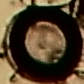

In [ ]:
Image.open(test_df.iloc[1905].img_path)

In [ ]:
test_df[test_df.target == 4]

,img_path,target,image_name
84,./test/images/20190402173125_OBJ_6_257_183.png,4,20190402173125_OBJ_6_257_183.png
136,./test/images/20190404113749_OBJ_6_62_588.png,4,20190404113749_OBJ_6_62_588.png
149,./test/images/20190404110645_OBJ_41_761_577.png,4,20190404110645_OBJ_41_761_577.png
171,./test/images/20190404111019_OBJ_13_593_464.png,4,20190404111019_OBJ_13_593_464.png
186,./test/images/20190404105614_OBJ_6_716_215.png,4,20190404105614_OBJ_6_716_215.png
...,...,...,...
1903,./test/images/20190402173130_OBJ_3_1027_489.png,4,20190402173130_OBJ_3_1027_489.png
1905,./test/images/20190404111129_OBJ_0_860_878.png,4,20190404111129_OBJ_0_860_878.png
1945,./test/images/20190404112640_OBJ_10_888_547.png,4,20190404112640_OBJ_10_888_547.png
1966,./test/images/20190402172132_OBJ_0_328_819.png,4,20190402172132_OBJ_0_328_819.png


In [ ]:
import json

In [ ]:
print(json.dumps(
    [{'Filename': str(i[1].image_name), 'Class': str(i[1].target)} for i in submission.iterrows()], separators=(',', ':')
))

[{"Filename":"20190404113255_OBJ_38_1224_449.png","Class":"2"},{"Filename":"20190404114614_OBJ_23_784_274.png","Class":"3"},{"Filename":"20190402170312_OBJ_4_861_329.png","Class":"1"},{"Filename":"20190404110633_OBJ_19_752_529.png","Class":"3"},{"Filename":"20190404111421_OBJ_19_900_495.png","Class":"2"},{"Filename":"20190404110824_OBJ_9_909_657.png","Class":"3"},{"Filename":"20190404112055_OBJ_14_327_474.png","Class":"1"},{"Filename":"20190404111159_OBJ_10_786_151.png","Class":"3"},{"Filename":"20190404114315_OBJ_1_1161_686.png","Class":"3"},{"Filename":"20190404105302_OBJ_10_183_293.png","Class":"1"},{"Filename":"20190404111519_OBJ_39_923_170.png","Class":"1"},{"Filename":"20190404113150_OBJ_36_604_94.png","Class":"3"},{"Filename":"20190404111417_OBJ_36_334_271.png","Class":"3"},{"Filename":"20190404113232_OBJ_5_743_844.png","Class":"3"},{"Filename":"20190404114509_OBJ_55_637_118.png","Class":"2"},{"Filename":"20190404111901_OBJ_7_496_636.png","Class":"1"},{"Filename":"20190404114628

In [ ]:
with open('data.json', 'w') as outfile:
    json.dump(
        [{'Filename': str(i[1].image_name), 'Class': str(i[1].target)} for i in submission.iterrows()], 
        outfile
    )